# Tomato Leaf Disease Detection – (Cross-Domain)

**Training:** PlantVillage (Healthy + Diseased)
**Testing:** TomatoVillage (Diseased only)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TP

Mounted at /content/drive
/content/drive/MyDrive/TP


In [ ]:
!pip install --upgrade timm albumentations torch grad-cam lime scikit-image onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 133.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.2
    Uninstalling scikit-image-0.25.2:
      Successfully uninstalled scikit-image-0.25.2


In [ ]:
import os, re, torch, timm, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------- DEVICE ----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------------- PATHS ----------------
TRAIN_ROOT = "/content/drive/MyDrive/TP/PlantVillage"
TEST_ROOT  = "/content/drive/MyDrive/TP/TomatoVillage"

# ---------------- LABEL NORMALIZATION ----------------
def normalize(name):
    name = name.lower()
    name = re.sub(r"tomato[_ ]*", "", name)
    name = re.sub(r"[^a-z ]", "", name)
    return name.replace(" ", "_")

raw_classes = sorted([d for d in os.listdir(TRAIN_ROOT) if os.path.isdir(os.path.join(TRAIN_ROOT,d))])
label_map = {normalize(c): i for i,c in enumerate(raw_classes)}
NUM_CLASSES = len(label_map)

# ---------------- TRANSFORMS ----------------
tf = A.Compose([
    A.Resize(224,224),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

# ---------------- DATASET ----------------
class TomatoDataset(Dataset):
    def __init__(self, root):
        self.samples = []
        for folder in os.listdir(root):
            key = normalize(folder)
            if key not in label_map: continue
            label = label_map[key]
            for f in os.listdir(os.path.join(root,folder)):
                if f.lower().endswith((".jpg",".png",".jpeg")):
                    self.samples.append((os.path.join(root,folder,f), label))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.array(Image.open(path).convert("RGB"))
        img = tf(image=img)["image"]
        return img, label

train_ds = TomatoDataset(TRAIN_ROOT)
test_ds  = TomatoDataset(TEST_ROOT)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# ---------------- TEACHER ENSEMBLE ----------------
teacher_archs = ["densenet121","resnet101","densenet201","efficientnet_b4"]
teachers = []

print("\nLoading teacher models...")
for arch in teacher_archs:
    m = timm.create_model(arch, pretrained=True, num_classes=NUM_CLASSES)
    for p in m.parameters(): p.requires_grad = False
    m.to(device).eval()
    teachers.append(m)
    print("✔", arch)

# ---------------- STUDENT MODEL ----------------
student = timm.create_model(
    "mobilenetv3_small_100",
    pretrained=True,
    num_classes=NUM_CLASSES
).to(device)


# ---------------- DISTILLATION SETUP ----------------
optimizer = optim.Adam(student.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")

TEMPERATURE = 4.0
ALPHA = 0.7
EPOCHS = 10   # small for fast execution

# ---------------- DISTILLATION TRAINING ----------------
print("\nTraining student model with knowledge distillation...")

for epoch in range(EPOCHS):
    student.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # ---- Teacher soft targets ----
        with torch.no_grad():
            teacher_probs = []
            for t in teachers:
                logits = t(images) / TEMPERATURE
                teacher_probs.append(torch.softmax(logits, dim=1))
            avg_teacher_prob = torch.mean(torch.stack(teacher_probs), dim=0)

        # ---- Student output ----
        student_logits = student(images)
        student_log_prob = torch.log_softmax(student_logits / TEMPERATURE, dim=1)

        # ---- Losses ----
        loss_soft = kl_loss(student_log_prob, avg_teacher_prob) * (TEMPERATURE**2)
        loss_hard = ce_loss(student_logits, labels)
        loss = ALPHA * loss_soft + (1 - ALPHA) * loss_hard

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | Distillation Loss: {loss.item():.4f}")

# ---------------- STUDENT EVALUATION ----------------
student.eval()
preds, labs = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = student(images)
        preds.extend(torch.argmax(outputs,1).cpu().numpy())
        labs.extend(labels.numpy())

acc = accuracy_score(labs, preds)
print("\nSTUDENT MODEL CROSS-DOMAIN ACCURACY:", round(acc*100,2))
print("\nClassification Report (Student):\n")
print(classification_report(labs, preds, zero_division=0))

Device: cuda

Loading teacher models...
✔ densenet121
✔ resnet101
✔ densenet201
✔ efficientnet_b4


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]


Training student model with knowledge distillation...
Epoch 1/10 | Distillation Loss: 0.5276
Epoch 2/10 | Distillation Loss: 0.4207
Epoch 3/10 | Distillation Loss: 0.4531
Epoch 4/10 | Distillation Loss: 0.4425
Epoch 5/10 | Distillation Loss: 0.3988
Epoch 6/10 | Distillation Loss: 0.4311
Epoch 7/10 | Distillation Loss: 0.4091
Epoch 8/10 | Distillation Loss: 0.4348
Epoch 9/10 | Distillation Loss: 0.3986
Epoch 10/10 | Distillation Loss: 0.3996

STUDENT MODEL CROSS-DOMAIN ACCURACY: 54.33

Classification Report (Student):

              precision    recall  f1-score   support

           1       0.47      0.05      0.08       496
           2       0.60      0.95      0.73       904
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.0

ModuleNotFoundError: No module named 'onnxscript'

In [ ]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 14.0 MB/s eta 0:00:00


In [ ]:
import onnxscript
# ---------------- DEPLOYMENT EXPORT ----------------
dummy = torch.randn(1,3,224,224)
torch.onnx.export(
    student.cpu(),
    dummy,
    "student_shufflenet_distilled.onnx",
    opset_version=18
)

print("\nDeployment Ready:")
print("student_shufflenet_distilled.onnx")

[torch.onnx] Obtain model graph for `MobileNetV3([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV3([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 68 of general pattern rewrite rules.

Deployment Ready:
student_shufflenet_distilled.onnx


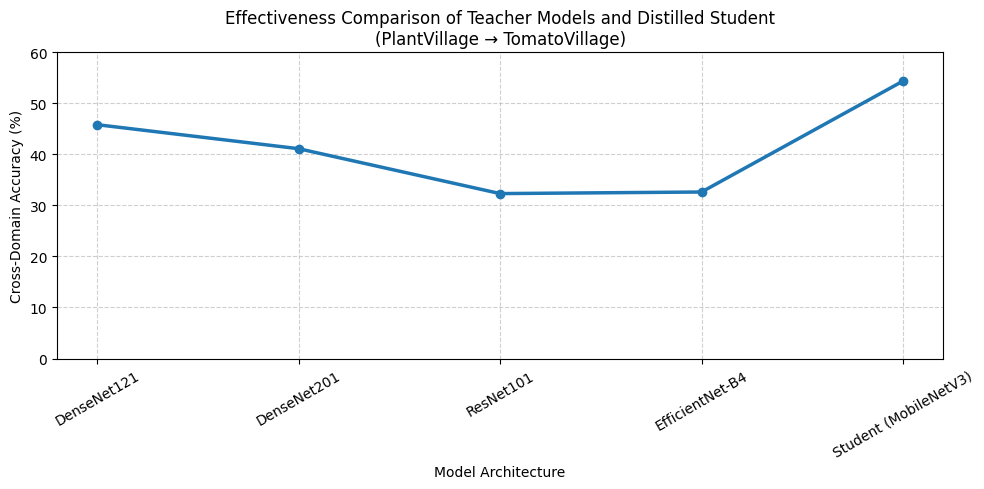

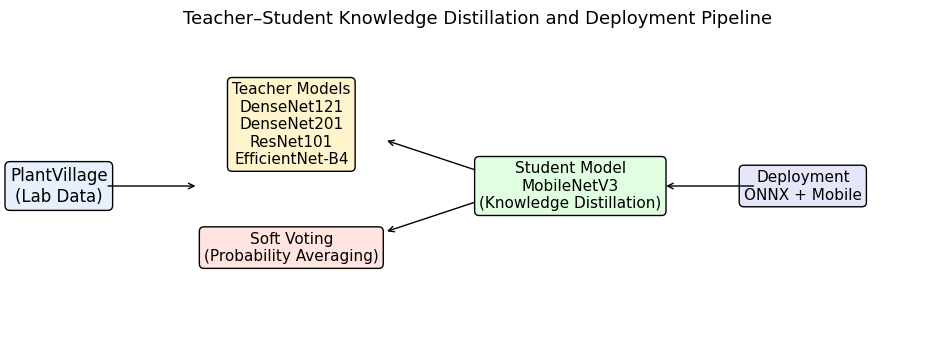

In [ ]:
# EFFECTIVENESS ANALYSIS: TEACHER MODELS vs STUDENT MODEL

import matplotlib.pyplot as plt
import numpy as np

# ---------------- ACCURACY VALUES (FROM YOUR RESULTS) ----------------
models = [
    "DenseNet121",
    "DenseNet201",
    "ResNet101",
    "EfficientNet-B4",
    "Student (MobileNetV3)"
]

accuracies = [
    45.79,   # DenseNet121
    41.09,   # DenseNet201
    32.30,   # ResNet101
    32.61,   # EfficientNet-B4
    54.33    # Student (MobileNetV3)
]

x = np.arange(len(models))

# ---------------- LINE GRAPH ----------------
plt.figure(figsize=(10,5))
plt.plot(x, accuracies, marker="o", linewidth=2.5)

plt.xticks(x, models, rotation=30)
plt.ylabel("Cross-Domain Accuracy (%)")
plt.xlabel("Model Architecture")
plt.title(
    "Effectiveness Comparison of Teacher Models and Distilled Student\n"
    "(PlantVillage → TomatoVillage)"
)
plt.ylim(0, 60)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# CONCEPTUAL PIPELINE DIAGRAM (TEXTUAL VISUALIZATION)

plt.figure(figsize=(12,4))
plt.axis("off")

plt.text(0.05, 0.5, "PlantVillage\n(Lab Data)", fontsize=12, ha="center", va="center",
         bbox=dict(boxstyle="round", fc="#E8F0FE"))

plt.text(0.30, 0.7,
         "Teacher Models\nDenseNet121\nDenseNet201\nResNet101\nEfficientNet-B4",
         fontsize=11, ha="center", va="center",
         bbox=dict(boxstyle="round", fc="#FFF4CC"))

plt.text(0.30, 0.3,
         "Soft Voting\n(Probability Averaging)",
         fontsize=11, ha="center", va="center",
         bbox=dict(boxstyle="round", fc="#FFE4E1"))

plt.text(0.60, 0.5,
         "Student Model\nMobileNetV3\n(Knowledge Distillation)",
         fontsize=11, ha="center", va="center",
         bbox=dict(boxstyle="round", fc="#E0FFE0"))

plt.text(0.85, 0.5,
         "Deployment\nONNX + Mobile",
         fontsize=11, ha="center", va="center",
         bbox=dict(boxstyle="round", fc="#E6E6FA"))

# Arrows
plt.annotate("", xy=(0.20,0.5), xytext=(0.10,0.5), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(0.40,0.65), xytext=(0.50,0.55), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(0.40,0.35), xytext=(0.50,0.45), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(0.70,0.5), xytext=(0.80,0.5), arrowprops=dict(arrowstyle="->"))

plt.title("Teacher–Student Knowledge Distillation and Deployment Pipeline", fontsize=13)
plt.show()


XAI for DenseNet121


  0%|          | 0/1000 [00:00<?, ?it/s]

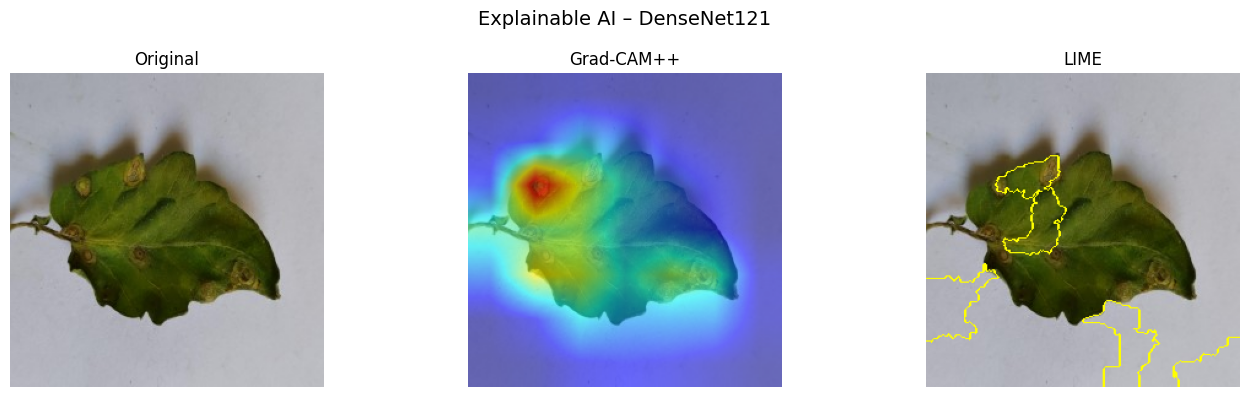


XAI for DenseNet201


  0%|          | 0/1000 [00:00<?, ?it/s]

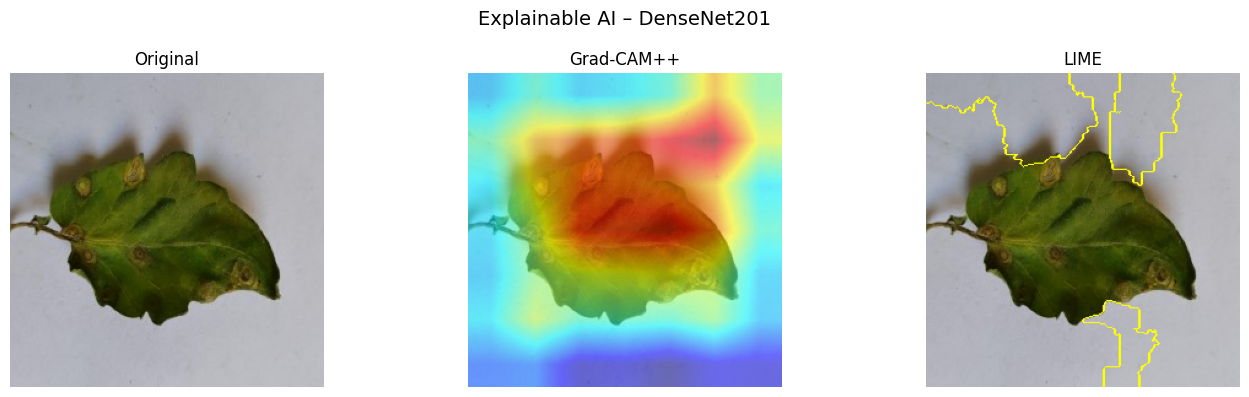


XAI for ResNet101


  0%|          | 0/1000 [00:00<?, ?it/s]

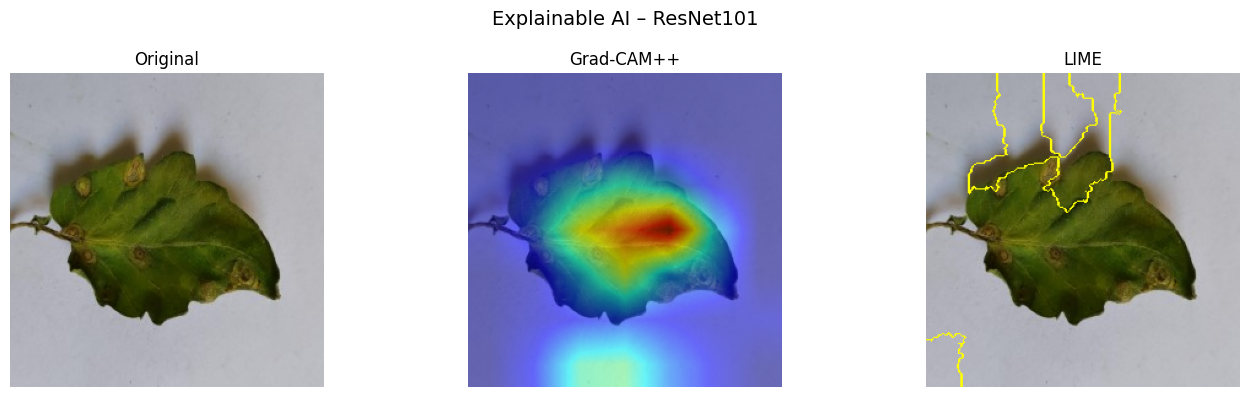


XAI for EfficientNet-B4


  0%|          | 0/1000 [00:00<?, ?it/s]

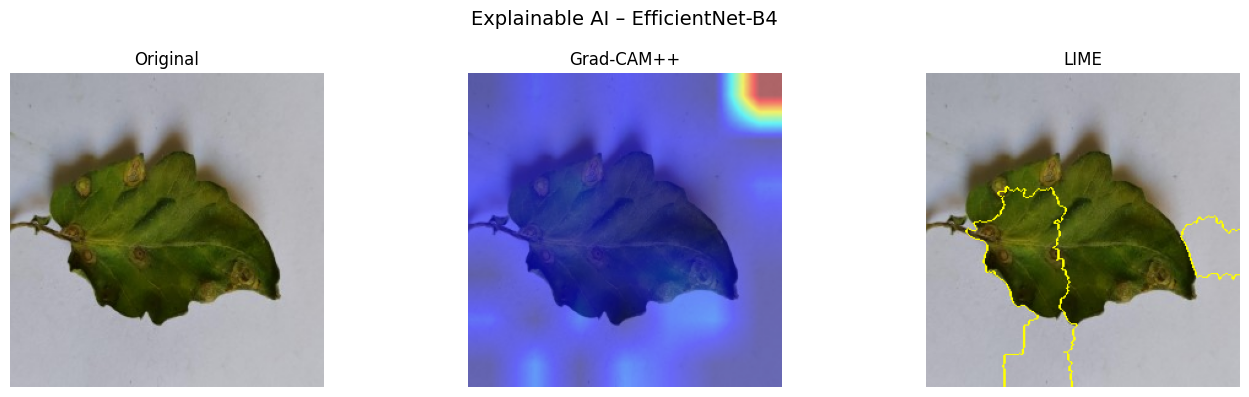

In [ ]:
# FINAL EXPLAINABLE AI: GRAD-CAM++ & LIME
# DenseNet | ResNet | EfficientNet | Student

import torch
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- TRANSFORM ----------------
transform = A.Compose([
    A.Resize(224,224),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

# ---------------- INPUT IMAGE ----------------
IMG_PATH = "/content/drive/MyDrive/TP/TomatoVillage/Early_blight/IMG20220323100125_1.jpg"
img = np.array(Image.open(IMG_PATH).convert("RGB"))
input_tensor = transform(image=img)["image"].unsqueeze(0).to(device)

# ---------------- MODELS ----------------
models = {
    "DenseNet121": ("densenet121", "densenet121_teacher.pth"),
    "DenseNet201": ("densenet201", "densenet201_teacher.pth"),
    "ResNet101": ("resnet101", "resnet101_teacher.pth"),
    "EfficientNet-B4": ("efficientnet_b4", "efficientnetb4_teacher.pth"),
}

# ---------------- LIME PREDICT ----------------
def lime_predict(images, model):
    batch = torch.stack([
        transform(image=i)["image"] for i in images
    ]).to(device)
    with torch.no_grad():
        return torch.softmax(model(batch), dim=1).cpu().numpy()

# XAI LOOP

for name, (arch, weights) in models.items():
    print(f"\nXAI for {name}")

    model = timm.create_model(arch, pretrained=False, num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(weights, map_location=device))
    model.to(device).eval()

    # ---------- CORRECT TARGET LAYERS ----------
    if "resnet" in arch:
        target_layers = [model.layer4[-1]]
    elif "densenet" in arch:
        target_layers = [model.features.norm5]
    elif "efficientnet" in arch:
        target_layers = [model.conv_head]

    # ---------- GRAD-CAM++ ----------
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
    class_idx = torch.argmax(model(input_tensor)).item()
    targets = [ClassifierOutputTarget(class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Resize CAM to input size
    grayscale_cam = cv2.resize(
        grayscale_cam,
        (img.shape[1], img.shape[0])
    )

    cam_image = show_cam_on_image(
        img / 255.0,
        grayscale_cam,
        use_rgb=True
    )

    # ---------- LIME ----------
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img,
        lambda x: lime_predict(x, model),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    lime_img, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # ---------- DISPLAY ----------
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam_image)
    plt.title("Grad-CAM++")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mark_boundaries(lime_img, mask))
    plt.title("LIME")
    plt.axis("off")

    plt.suptitle(f"Explainable AI – {name}", fontsize=14)
    plt.tight_layout()
    plt.show()